# Assignment for practical work 4. Basics of neural networks

Group:

*  Jannik Bucher
*  Dennis Imhof

### Using dataset: Page Blocks Dataset
[Page Blocks Dataset](https://archive.ics.uci.edu/ml/datasets/Page+Blocks+Classification)

## General Assignment

Before performing the practical work, you need download the data set accordingly to the option on your machine
1. Write a program that splits the original sample into a training set and a test set (training set, validation set, test set)
2. Build a model using Perceptron (http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) and MLPClassifier (http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html). On the basis of experiments, select values for learning rate, the regularization parameter, the optimization function.
3. Build learning curves for better explanation of your experiments.

## Options
Data sets are taken from the UCI Machine Learning Repository
https://archive.ics.uci.edu/ml/
The option is determined by the data set, which can be downloaded from the link above:
The option is determined by the data set, which can be downloaded from the link above:
1. Sponge
2. Water Treatment Plant
3. Synthetic Control Chart Time Series
4. Character Trajectories
5. Plants
6. Libras Movement
7. KEGG Metabolic Relation Network (Directed)
8. SMS Spam Collection
9. seeds
10. Human Activity Recognition Using Smartphones
11. User Knowledge Modeling
12. NYSK
13. Activities of Daily Living (ADLs) Recognition Using Binary Sensors
14. Dresses_Attribute_Sales
15. Wholesale customers
16. StoneFlakes
17. Gesture Phase Segmentation
18. AAAI 2014 Accepted Papers
19. Dow Jones Index
20. AAAI 2013 Accepted Papers
21. wiki4HE
22. Folio
23. Mice Protein Expression
24. Improved Spiral Test Using Digitized Graphics Tablet for Monitoring Parkinson’s Disease


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import validation_curve, learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from keras import models
from keras import layers
from keras import utils
from keras import optimizers

Using TensorFlow backend.


In [2]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(9,9))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="orange")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1)
    plt.plot(train_sizes, train_scores_mean, 'o-', color="darkorange",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-',
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [3]:
def plot_validation_curve(estimator, title, X, y, param_name, param_range, scoring="accuracy"):
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=3, scoring=scoring, n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    
    best_test_param = param_range[np.argmax(test_scores_mean)]
    best_train_param = param_range[np.argmax(train_scores_mean)]

    best_test_score = np.max(test_scores_mean)
    best_train_score = np.max(train_scores_mean)
    
    
    plt.figure(figsize=(9,9))
    plt.title("Validation Curve {}: {} vs {}\nBest train param: {} - score: {}\nBest test param: {} - score {}".format(title, 
                                                                                                                       scoring, 
                                                                                                                       param_name, 
                                                                                                                       best_train_param, 
                                                                                                                       best_train_score, 
                                                                                                                       best_test_param,
                                                                                                                       best_test_score))
    plt.xlabel("{}".format(param_name))
    plt.ylabel("{}".format(scoring))
    #plt.ylim(0.1, 0.4)
    plt.axvline(best_test_param, color='darkorange', linestyle='--', label="best train param")
    plt.axvline(best_train_param, color='navy', linestyle='--', label="best test param")
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, lw=lw)
    plt.legend(loc="best")
    plt.show()

# Page-Blocks dataset

In [4]:
elements = []
with open('data/page-blocks.data') as f:
    for l in f:       
        elements.append([float(x) for x in l.split()])
        
elements = np.array(elements)

In [5]:
columns = ['height', 
           'lenght', 
           'area',
           'eccen',
           'p_black',
           'p_and',
           'mean_tr',
           'blackpix',
           'blackand',
           'wb_trans',
           'block']

In [6]:
df = pd.DataFrame(elements, columns=columns)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("block", axis=1), df["block"], train_size=0.7, random_state=42)

In [8]:
X_train.describe()

,height,lenght,area,eccen,p_black,p_and,mean_tr,blackpix,blackand,wb_trans
count,3831.000000,3831.000000,3831.000000,3831.000000,3831.000000,3831.000000,3831.000000,3831.000000,3831.000000,3831.000000
mean,10.168102,88.115636,1182.607935,13.197051,0.367214,0.785362,6.415409,354.974158,725.282172,105.078831
std,14.038977,114.094530,4999.354600,29.384528,0.176054,0.170014,81.630229,1302.946891,1912.952788,162.250784
min,1.000000,1.000000,7.000000,0.007000,0.052000,0.062000,1.000000,7.000000,7.000000,1.000000
25%,7.000000,17.000000,112.000000,2.111000,0.261000,0.680500,1.610000,42.000000,94.000000,17.000000
50%,8.000000,40.000000,320.000000,5.111000,0.337000,0.804000,2.070000,105.000000,246.000000,48.000000
75%,10.000000,104.000000,960.000000,13.309500,0.424000,0.925000,2.990000,278.000000,698.500000,123.000000
max,311.000000,553.000000,143993.000000,413.000000,1.000000,1.000000,4955.000000,33017.000000,46133.000000,3212.000000


## Normalizing the data

In [9]:
scale = StandardScaler()

In [10]:
X_train_scaled = pd.DataFrame(scale.fit_transform(X_train), columns=X_train.columns)

# Perceptron

## Comparing performance of scaled and unscaled data

#### Unscaled inputs

In [11]:
cv_scores = cross_val_score(Perceptron(random_state=42), X_train, y_train, cv=5, n_jobs=-1, scoring="accuracy")
cv_scores

array([0.93237971, 0.73307292, 0.67232376, 0.91361257, 0.93193717])

In [12]:
np.mean(cv_scores)

0.836665225718372

#### Scaled inputs

In [13]:
cv_scores = cross_val_score(Perceptron(random_state=42), X_train_scaled, y_train, cv=5, n_jobs=-1, scoring="accuracy")
cv_scores

array([0.90117035, 0.94270833, 0.96605744, 0.95287958, 0.94240838])

In [14]:
np.mean(cv_scores)

0.9410448167614224

The (unoptimized) model performs much better with the scaled inputs. We will therefore use the scaled inputs for further analysis.

## Tuning hyperparameters
As we've seen above the cross-validation accuracy of both models is already pretty high (94%-97%). Let's see how much we can improve the models by tuning hyperparameters. 

In [15]:
param_perc_dist = {"penalty":[None, 'l1', 'l2', 'elasticnet'],
              "alpha":np.logspace(-7, 0, 30),
              "max_iter" : np.arange(100,2000, 200),
              "eta0": [0.1, 0.5, 1]}

In [16]:
rand_perc = RandomizedSearchCV(Perceptron(random_state=42), param_distributions=param_perc_dist, n_iter=500, scoring="accuracy", cv=3, verbose=1, random_state=42)

In [17]:
rand_perc.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:   16.3s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=Perceptron(alpha=0.0001, class_weight=None,
                                        early_stopping=False, eta0=1.0,
                                        fit_intercept=True, max_iter=1000,
                                        n_iter_no_change=5, n_jobs=None,
                                        penalty=None, random_state=42,
                                        shuffle=True, tol=0.001,
                                        validation_fraction=0.1, verbose=0,
                                        warm_start=False),
                   iid='warn', n_iter=500, n_jobs=None,
                   param_dist...
       6.72335754e-03, 1.17210230e-02, 2.04335972e-02, 3.56224789e-02,
       6.21016942e-02, 1.08263673e-01, 1.88739182e-01, 3.29034456e-01,
       5.73615251e-01, 1.00000000e+00]),
                                        'eta0': [0.1, 0.5, 1],
                                        'ma

In [18]:
perc_best_penalty, perc_best_max_iter = rand_perc.best_params_['penalty'], rand_perc.best_params_['max_iter']

In [19]:
rand_perc.best_params_, rand_perc.best_score_

({'penalty': 'l1',
  'max_iter': 1300,
  'eta0': 0.5,
  'alpha': 2.8072162039411756e-06},
 0.9556251631427826)

Out of those 2500 fits the 'l1' regularization and max_iter=1300 come out as most favourable. We will now look a bit closer at eta0, the learning rate, and alpha, the constant multiplying the regularization term.

In [20]:
param_perc_grid = {'alpha':np.logspace(-7,0, 50),
              'eta0':np.logspace(-4,0, 30)}
grid_perc = GridSearchCV(Perceptron(penalty=perc_best_penalty, max_iter=perc_best_max_iter, random_state=42), param_grid=param_perc_grid, scoring="accuracy", n_jobs=-1, cv=5)

In [21]:
grid_perc.fit(X_train_scaled, y_train)

/home/snbl/HDD/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Perceptron(alpha=0.0001, class_weight=None,
                                  early_stopping=False, eta0=1.0,
                                  fit_intercept=True, max_iter=1300,
                                  n_iter_no_change=5, n_jobs=None, penalty='l1',
                                  random_state=42, shuffle=True, tol=0.001,
                                  validation_fraction=0.1, verbose=0,
                                  warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': array([1....
       4.52035366e-03, 6.21016942e-03, 8.53167852e-03, 1.17210230e-02,
       1.61026203e-02, 2.21221629e-02, 3.03919538e-02, 4.17531894e-02,
       5.73615251e-02, 7.88046282e-02, 1.08263673e-01, 1.48735211e-01,
       2.04335972e-01, 2.80721620e-01, 3.85662042e-01, 5.29831691e-01,
       7.27895384e-01, 1.00000000e+00])},
             pre_dispatch='2*n_jobs', refit=True, return_

In [22]:
perc_best_alpha, perc_best_eta0 = grid_perc.best_params_['alpha'], grid_perc.best_params_['eta0']

In [23]:
grid_perc.best_params_, grid_perc.best_score_

({'alpha': 0.00019306977288832496, 'eta0': 0.1082636733874054},
 0.953275907073871)

## Validation curves

Performing an exhaustive grid search over eta0 and alpha lead to slightly different parameters and an increase in accuracy of 0.1%. Let's look at validation curves for both parameters independently.

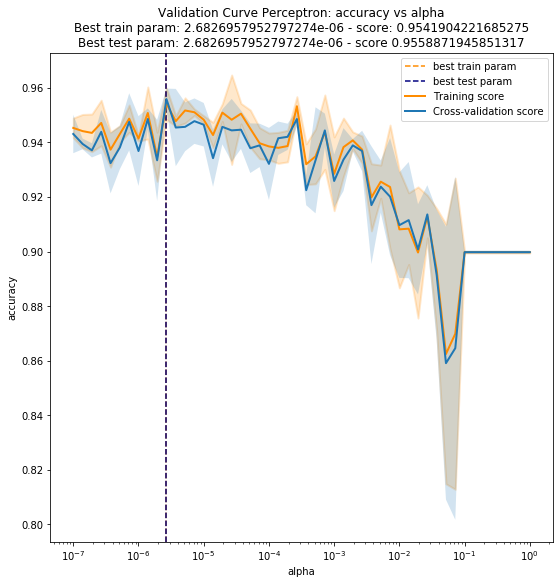

In [24]:
plot_validation_curve(Perceptron(penalty=perc_best_penalty, 
                                 alpha=perc_best_eta0,
                                 max_iter=perc_best_max_iter,
                                 random_state=42), "Perceptron", X_train_scaled, y_train, "alpha", param_perc_grid['alpha'])

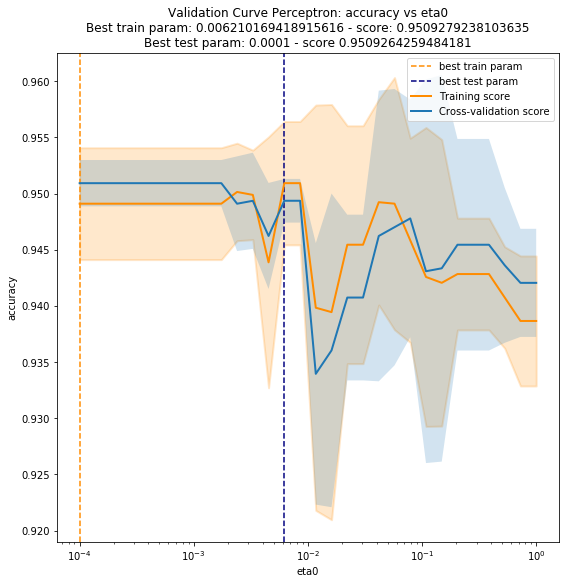

In [25]:
plot_validation_curve(Perceptron(penalty=perc_best_penalty, 
                                 alpha=perc_best_alpha,
                                 max_iter=perc_best_max_iter,
                                 random_state=42), "Perceptron", X_train_scaled, y_train, "eta0", param_perc_grid['eta0'])

## Learning curve

Let's take a look at the learning curve using the best parameters found through RandomizedSearchCV and GridSearchCV.

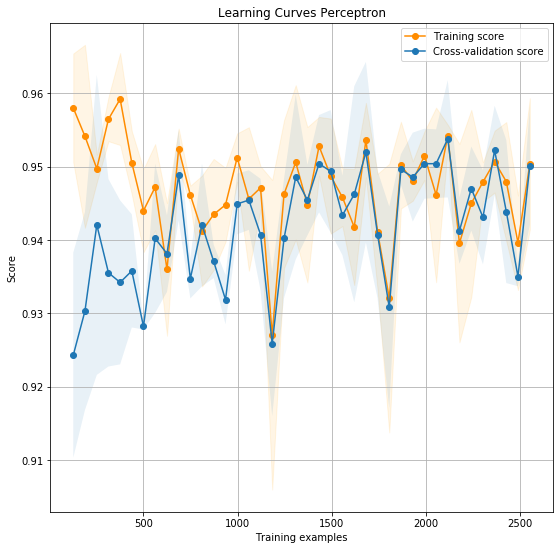

In [26]:
perc = Perceptron(random_state=42,
                  penalty=perc_best_penalty, 
                  alpha=perc_best_alpha, 
                  eta0=perc_best_eta0, 
                  max_iter=perc_best_max_iter)
plot_learning_curve(perc, "Learning Curves Perceptron", X_train_scaled, y_train, cv=3, n_jobs=-1, 
                    train_sizes=np.linspace(0.05,1, 40))

plt.show()

We can see the training and test score converge with 94%-95% accuracy. This means that our model is neither underfitted nor overfitted.

The best score we could reach through tuning with GridSearchCV was 95.3% accuracy, which is ~0.3% higher than the Perceptron model with default parameters.

# Multi Layer Perceptron Classifier

#### Unscaled inputs

In [27]:
cv_scores = cross_val_score(MLPClassifier(random_state=42), X_train, y_train, cv=5, n_jobs=-1, scoring="accuracy")
cv_scores

array([0.95968791, 0.96614583, 0.96475196, 0.88481675, 0.96073298])

In [28]:
np.mean(cv_scores)

0.9472270872299366

#### Scaled inputs

In [29]:
cv_scores = cross_val_score(MLPClassifier(random_state=42), X_train_scaled, y_train, cv=5, n_jobs=-1, scoring="accuracy")
cv_scores

array([0.96358908, 0.96223958, 0.97911227, 0.98167539, 0.97120419])

In [30]:
np.mean(cv_scores)

0.9715641025497306

We find that the MLPClassifier like the Perceptron responds to the scaled data with increased accuracy.

## Tuning hyperparameters
As we've seen above the cross-validation accuracy of the model is already pretty high (97.1%). Let's see how much we can improve the model by tuning hyperparameters. Before we start looking at the learning rate and regularization parameter, we will search for a good number of hidden layers and their respective sizes.

#### Find the optimal layer sizes

In [31]:
param_mlp_grid = {'hidden_layer_sizes' : [(x,) for x in np.arange(100, 500, 100)] + [(x,y) for x in np.arange(100, 500, 100) for y in np.arange(100, 500, 200)],
                  'solver': ['lbfgs', 'sgd', 'adam'],
                  'learning_rate': ['constant', 'invscaling', 'adaptive']}

In [32]:
grid_mlp = GridSearchCV(MLPClassifier(random_state=42), param_grid=param_mlp_grid, scoring="accuracy", cv=3, n_jobs=-1, verbose=5)
grid_mlp.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 44.3min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed: 59.7min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=200,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_sta...
                                     warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(100,), (200,), (300,), (400,),
                                                (100, 100), (100, 300),
                                                (200, 100), (200, 300),
    

In [33]:
mlp_best_hidden_layers, mlp_best_solver = grid_mlp.best_params_['hidden_layer_sizes'], grid_mlp.best_params_['solver']

In [34]:
grid_mlp.best_params_, grid_mlp.best_score_

({'hidden_layer_sizes': (400,), 'learning_rate': 'constant', 'solver': 'adam'},
 0.9731140694335683)

Great, a model with 2 hidden layers with 200 and 300 neurons utilizing the ADAM-optimizer results in an accuracy of 97.31% which is 0.2% higher than the default.

### Learning Rate
Let's also see if there is a preferable behaviour of the learning rate

In [35]:
param_mlp_grid = {'learning_rate' : ["constant", "invscaling", "adaptive"]}
grid_mlp = GridSearchCV(MLPClassifier(hidden_layer_sizes=mlp_best_hidden_layers,
                                       solver=mlp_best_solver,
                                       random_state=42,
                                       verbose=1),
                         param_grid=param_mlp_grid, 
                         scoring="accuracy", 
                         cv=3, 
                         n_jobs=-1)
grid_mlp.fit(X_train_scaled, y_train)

Iteration 1, loss = 1.20594384
Iteration 2, loss = 0.58171118
Iteration 3, loss = 0.35838703
Iteration 4, loss = 0.27450555
Iteration 5, loss = 0.23271532
Iteration 6, loss = 0.20584371
Iteration 7, loss = 0.18803907
Iteration 8, loss = 0.17291697
Iteration 9, loss = 0.16176006
Iteration 10, loss = 0.15194128
Iteration 11, loss = 0.14458041
Iteration 12, loss = 0.13780352
Iteration 13, loss = 0.13345655
Iteration 14, loss = 0.12894605
Iteration 15, loss = 0.12430279
Iteration 16, loss = 0.12142584
Iteration 17, loss = 0.11782709
Iteration 18, loss = 0.11562424
Iteration 19, loss = 0.11238660
Iteration 20, loss = 0.11050041
Iteration 21, loss = 0.10814165
Iteration 22, loss = 0.10732295
Iteration 23, loss = 0.10456546
Iteration 24, loss = 0.10339190
Iteration 25, loss = 0.10137862
Iteration 26, loss = 0.10012281
Iteration 27, loss = 0.09975509
Iteration 28, loss = 0.09874356
Iteration 29, loss = 0.09873309
Iteration 30, loss = 0.09607850
Iteration 31, loss = 0.09513540
Iteration 32, los

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(400,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=200,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=42, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=1,
                                     warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': ['constant', 'invscaling',
     

In [36]:
mlp_best_learning_rate = grid_mlp.best_params_['learning_rate']

In [37]:
grid_mlp.best_params_, grid_mlp.best_score_

({'learning_rate': 'constant'}, 0.9731140694335683)

### Find the optimal regularization parameter
Let us first look at a validation curve for the regularization parameter alpha

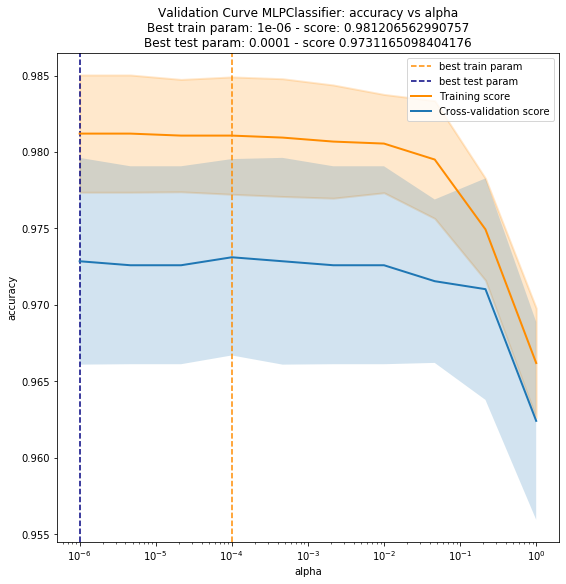

In [38]:
param_mlp_grid = {'alpha' : np.logspace(-6,0, 10)}
plot_validation_curve(MLPClassifier(hidden_layer_sizes=mlp_best_hidden_layers,
                                    solver=mlp_best_solver,
                                    learning_rate=mlp_best_learning_rate,
                                    random_state=42), "MLPClassifier", X_train_scaled, y_train, "alpha", param_mlp_grid['alpha'])

The training and cross-validation accuracy stays relatively the same over the full range of the alphas until both dramatically drop from $10^{-1}$ on.

In [39]:
param_mlp_grid = {'alpha' : np.logspace(-6,-3, 4)}
grid_mlp = GridSearchCV(MLPClassifier(hidden_layer_sizes=mlp_best_hidden_layers,
                                       solver=mlp_best_solver,
                                       learning_rate=mlp_best_learning_rate,
                                       random_state=42), 
                         param_grid=param_mlp_grid, 
                         scoring="accuracy", 
                         cv=3, 
                         n_jobs=-1)
grid_mlp.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(400,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=200,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=42, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-0

In [40]:
mlp_best_alpha = grid_mlp.best_params_['alpha']

In [41]:
grid_mlp.best_params_, grid_mlp.best_score_

({'alpha': 0.0001}, 0.9731140694335683)

### Learning curve

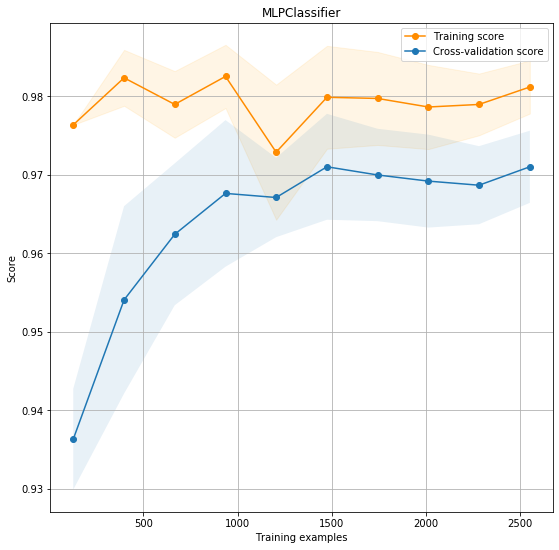

In [42]:
mlp = MLPClassifier(hidden_layer_sizes=mlp_best_hidden_layers,
              learning_rate=mlp_best_learning_rate,
              solver=mlp_best_solver,
              alpha=mlp_best_alpha,
              random_state=42)

plot_learning_curve(mlp, "MLPClassifier", X_train_scaled, y_train, cv=3, n_jobs=-1, 
                    train_sizes=np.linspace(0.05, 1, 10))

plt.show()

We can see that the train and cross-validation scores initially being far apart converge to a difference of about 0.5%-1% accuracy.

# Test scores

In [43]:
X_test_scaled = scale.fit_transform(X_test)

### Perceptron

In [44]:
perc.fit(X_train_scaled, y_train)
perc_pred = perc.predict(X_test_scaled)
accuracy_score(y_test, perc_pred)

0.9390986601705238

In [45]:
print(classification_report(y_test, perc_pred))

              precision    recall  f1-score   support

         1.0       0.95      0.99      0.97      1466
         2.0       0.88      0.63      0.74       106
         3.0       0.50      0.70      0.58        10
         4.0       0.83      0.32      0.47        31
         5.0       0.71      0.34      0.47        29

    accuracy                           0.94      1642
   macro avg       0.78      0.60      0.64      1642
weighted avg       0.94      0.94      0.93      1642



### Multi Layer Perceptron

In [46]:
mlp.fit(X_train_scaled, y_train)
mlp_pred = mlp.predict(X_test_scaled)
accuracy_score(y_test, mlp_pred)

0.9531059683313033

In [47]:
print(classification_report(y_test, mlp_pred))

              precision    recall  f1-score   support

         1.0       0.96      0.99      0.98      1466
         2.0       0.89      0.75      0.82       106
         3.0       0.75      0.30      0.43        10
         4.0       0.89      0.55      0.68        31
         5.0       0.83      0.34      0.49        29

    accuracy                           0.95      1642
   macro avg       0.87      0.59      0.68      1642
weighted avg       0.95      0.95      0.95      1642



### Random Forest and Gradient Boosting

Tuning the hyperparameters and fitting the models took a while. Let's s compare the results of the neural networks with a random forest and the gradient boosting algorithm.

In [48]:
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
cross_val_score(rf, X_train_scaled, y_train, scoring="accuracy", cv=10, verbose=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.7s finished


array([0.96623377, 0.97142857, 0.95844156, 0.97135417, 0.96354167,
       0.984375  , 0.98694517, 0.97375328, 0.97368421, 0.97631579])

In [49]:
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [50]:
rf_pred = rf.predict(X_test_scaled)
accuracy_score(y_test, rf_pred)

0.9579780755176613

In [51]:
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

         1.0       0.96      0.99      0.98      1466
         2.0       0.94      0.71      0.81       106
         3.0       0.62      0.50      0.56        10
         4.0       0.84      0.84      0.84        31
         5.0       0.85      0.38      0.52        29

    accuracy                           0.96      1642
   macro avg       0.84      0.68      0.74      1642
weighted avg       0.96      0.96      0.95      1642



### XGBoost

In [52]:
xgb = GradientBoostingClassifier(n_estimators=100, max_features=5)
cross_val_score(xgb, X_train_scaled, y_train, scoring="accuracy", cv=10, verbose=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.8s finished


array([0.96883117, 0.97662338, 0.96103896, 0.95833333, 0.96614583,
       0.97916667, 0.9843342 , 0.97112861, 0.96578947, 0.97894737])

In [53]:
xgb.fit(X_train_scaled, y_train)
xgb_pred = xgb.predict(X_test_scaled)
accuracy_score(y_test, xgb_pred)

0.9549330085261876

In [54]:
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

         1.0       0.96      0.99      0.98      1466
         2.0       0.96      0.64      0.77       106
         3.0       1.00      0.40      0.57        10
         4.0       0.84      0.87      0.86        31
         5.0       0.72      0.45      0.55        29

    accuracy                           0.95      1642
   macro avg       0.90      0.67      0.75      1642
weighted avg       0.95      0.95      0.95      1642



### Building a Neural Net Classifier with Keras

In [55]:
y_train_ohe = utils.np_utils.to_categorical(y_train)
y_test_ohe = utils.np_utils.to_categorical(y_test)

In [56]:
model = models.Sequential()

In [57]:
model.add(layers.Dense(300, activation='relu', input_dim=10))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='tanh'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))

In [58]:
model.compile(optimizer='adam',          
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [59]:
hist = model.fit(X_train_scaled, 
                 y_train_ohe, 
                 epochs=100, 
                 workers=-1, 
                 batch_size=512, 
                 verbose=False,
                 validation_data=(X_test_scaled, y_test_ohe))

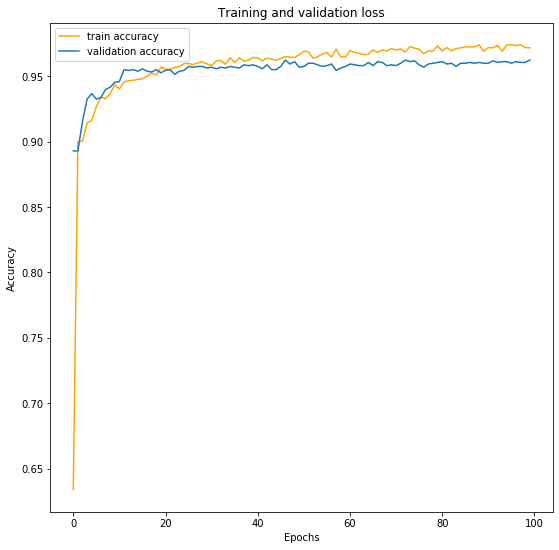

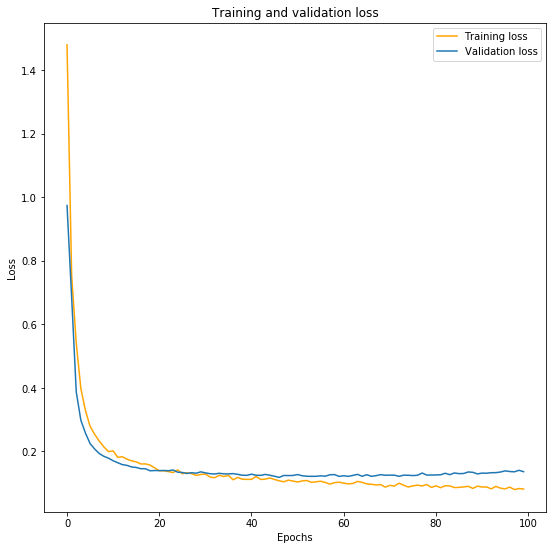

In [60]:
plt.figure(figsize=(9,9))
plt.title('Training and validation loss')
plt.plot(hist.epoch, hist.history['accuracy'], color="orange", linestyle="-", label="train accuracy")
plt.plot(hist.epoch, hist.history['val_accuracy'],  linestyle="-", label="validation accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()


plt.figure(figsize=(9,9))
plt.plot(hist.epoch, hist.history['loss'], color="orange", label='Training loss')
plt.plot(hist.epoch, hist.history['val_loss'], label='Validation loss')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title('Training and validation loss')
plt.legend();


In [61]:
pred_keras = model.predict_classes(X_test_scaled)

In [62]:
print(classification_report(y_test, pred_keras))

              precision    recall  f1-score   support

         1.0       0.97      0.99      0.98      1466
         2.0       0.89      0.84      0.86       106
         3.0       0.71      0.50      0.59        10
         4.0       0.88      0.68      0.76        31
         5.0       0.76      0.45      0.57        29

    accuracy                           0.96      1642
   macro avg       0.84      0.69      0.75      1642
weighted avg       0.96      0.96      0.96      1642



#### Compared with the SciKit MLPClassifier

In [63]:
print(classification_report(y_test, mlp_pred))

              precision    recall  f1-score   support

         1.0       0.96      0.99      0.98      1466
         2.0       0.89      0.75      0.82       106
         3.0       0.75      0.30      0.43        10
         4.0       0.89      0.55      0.68        31
         5.0       0.83      0.34      0.49        29

    accuracy                           0.95      1642
   macro avg       0.87      0.59      0.68      1642
weighted avg       0.95      0.95      0.95      1642



As final experiment we tried fitting our data to a convolutional network.

In [65]:
X_train_tensor = X_train_scaled.values.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_tensor = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

In [66]:
model = models.Sequential()

model.add(layers.Conv1D(32, 3, activation='relu', input_shape=(10,1)))
model.add(layers.MaxPooling1D(2, padding="same"))
model.add(layers.Conv1D(64, 3, activation='relu', padding="same"))
model.add(layers.MaxPooling1D(2, padding="same"))
model.add(layers.Conv1D(128, 3, activation='relu', padding="same"))
model.add(layers.MaxPooling1D(2, padding="same"))
model.add(layers.Conv1D(128, 3, activation='relu', padding="same"))
model.add(layers.MaxPooling1D(2, padding="same"))
model.add(layers.Conv1D(128, 3, activation='relu', padding="same"))
model.add(layers.MaxPooling1D(2, padding="same"))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(300, activation="relu"))
model.add(layers.Dense(300, activation="relu"))
model.add(layers.Dense(6, activation="softmax"))

In [67]:
model.compile(optimizer="adam",
             loss="categorical_crossentropy",
             metrics=["accuracy"])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 8, 32)             128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4, 32)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4, 64)             6208      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2, 64)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2, 128)            24704     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1, 128)           

In [68]:
hist = model.fit(X_train_tensor, y_train_ohe, epochs=40, validation_data=(X_test_tensor, y_test_ohe), verbose=False)

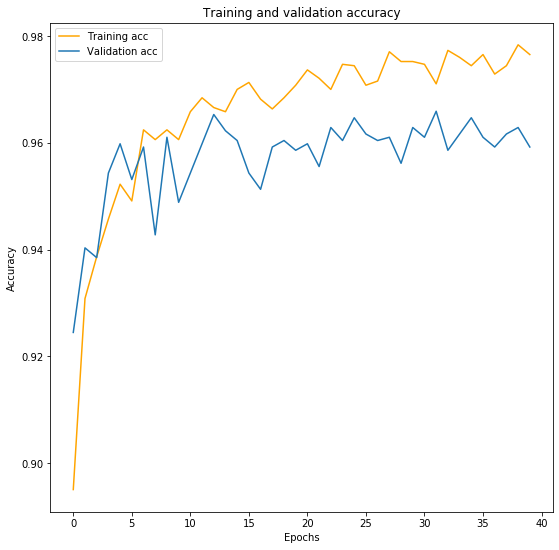

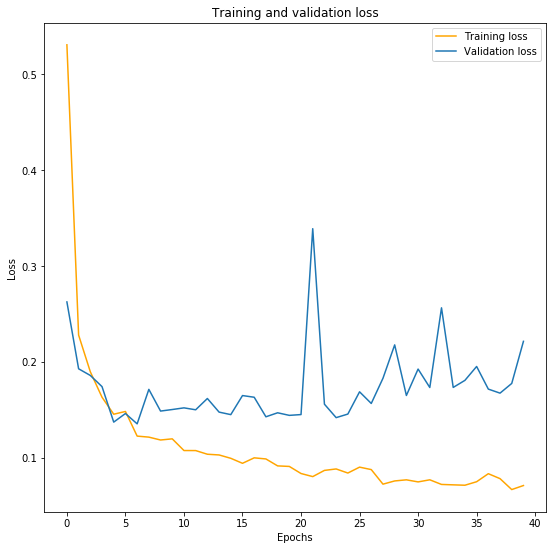

In [69]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(9,9))
plt.plot(epochs, acc, color="orange", label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(9,9))
plt.plot(epochs, loss, color="orange", label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [70]:
print(classification_report(model.predict_classes(X_test_tensor), y_test))

              precision    recall  f1-score   support

           1       0.99      0.97      0.98      1496
           2       0.80      0.94      0.87        90
           3       0.30      0.30      0.30        10
           4       0.68      0.78      0.72        27
           5       0.48      0.74      0.58        19

    accuracy                           0.96      1642
   macro avg       0.65      0.75      0.69      1642
weighted avg       0.96      0.96      0.96      1642



# Conclusion

Though it took a lot longer to tune and train the MLPClassifier it definitly was worth it. 

Compared to the Perceptron, RandomForst and XGBoost models it performs better in accuracy and F1 score. 

By creating a neural network in Keras using Dense- and Dropout layers we could improve on the performance of the MLPClassifier and obtain a test accuracy of 96%. The F1-score also improved from 0.68 to 0.74. This results from a much better recall and only slightly worse precision of our custom Keras model. 

By fitting a convolutional neural network we could even reach an accuracy score of 97%.